# **Machine Learning: Project Part 1**

---

**Author: Damien Farrell**

---

In [135]:
# Imports

import os
import gc
import torch
import whisper
import whisperx
import pandas as pd
import seaborn as sns
import numpy as np
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import pipeline as transformers_pipeline
from pyannote.audio import Pipeline as AudioPipeline
from pyannote.audio.pipelines.utils.hook import ProgressHook

sns.set_theme()

In [2]:
# Environment Variables
load_dotenv()
HF_API_KEY = os.getenv("HF_API_KEY")
assert HF_API_KEY, "Please set your Hugging Face API key in the HF_API_KEY environment variable."

# Audio File Path
AUDIO_FILE_PATH = "./audio/TrumpHarrisDebate.wav"
assert AUDIO_FILE_PATH, "Please place your audio in a folder called 'audio'. Note: use backslashes if on Windows"

## **Project Part 1: Interview/Debate Audio Analysis**

> 1. **Performs Speaker Diarisation Analysis**  
>    - Uses pre-built models to identify who spoke and when.  
>    - Outputs time segments for each speaker and calculates total speaking time.
> <br><br>
> 2. **Performs Speech to Text Analysis**  
>    - Transcribes the audio for each speaker.  
>    - Combines speaker labels with the transcript (e.g., “[Speaker 1] …”).  
>    - Allows for further analysis, such as word counts or word frequency per speaker.
> <br><br>
> 3. **Leverage a Large Language Model**  
>    - Once the transcript is annotated, the notebook can query a large language model for sentiment or ideological analysis.  
>    - Could identify speaker names or approximate political leanings based on transcript content.
> <br><br>
> 4. **Testing & Evaluation**  
>    - An audio file of the “Harris vs. Trump 2024 US Presidential Debate” will be provided for initial testing.  
>    - A more complex file (with additional speakers or speakers of similar gender) should be used for further evaluation.  
>    - The performance of each component should be documented and assessed.
> <br><br>


---

### **1. Performs Speaker Diarisation Analysis** 

---

In [3]:
# instantiate the pipeline
pipeline = AudioPipeline.from_pretrained(
  "pyannote/speaker-diarization-3.1",
  use_auth_token="HF_API_KEY")

In [4]:
# run the pipeline on an audio file
with ProgressHook() as hook:
    diarisation = pipeline(AUDIO_FILE_PATH, hook=hook)

Output()

/home/damien/Documents/ATU/machine-learning/.venv/lib/python3.12/site-packages/pyannote/audio/models/blocks/pooling
.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction 
factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = sequences.std(dim=-1, correction=1)

In [5]:
print(diarisation)

[ 00:00:01.836 -->  00:00:03.034] A SPEAKER_02
[ 00:00:03.152 -->  00:00:04.671] B SPEAKER_02
[ 00:00:04.806 -->  00:00:05.211] C SPEAKER_02
[ 00:00:06.679 -->  00:00:10.037] D SPEAKER_00
[ 00:00:10.257 -->  00:00:20.449] E SPEAKER_01
[ 00:00:20.922 -->  00:00:29.697] F SPEAKER_02
[ 00:00:30.068 -->  00:00:52.512] G SPEAKER_01
[ 00:00:52.799 -->  00:00:55.600] H SPEAKER_02
[ 00:00:56.039 -->  00:01:22.566] I SPEAKER_02
[ 00:01:23.005 -->  00:01:37.214] J SPEAKER_01
[ 00:01:37.214 -->  00:01:37.281] K SPEAKER_00
[ 00:01:37.669 -->  00:01:42.512] L SPEAKER_00
[ 00:01:40.352 -->  00:01:41.196] M SPEAKER_02
[ 00:01:43.187 -->  00:01:45.060] N SPEAKER_02
[ 00:01:46.259 -->  00:01:49.245] O SPEAKER_00
[ 00:01:48.385 -->  00:01:55.607] P SPEAKER_01
[ 00:01:49.887 -->  00:01:51.861] Q SPEAKER_00
[ 00:01:55.624 -->  00:02:08.230] R SPEAKER_00
[ 00:02:08.230 -->  00:02:11.267] S SPEAKER_02
[ 00:02:11.892 -->  00:02:19.637] T SPEAKER_02
[ 00:02:20.076 -->  00:02:26.252] U SPEAKER_02
[ 00:02:26.70

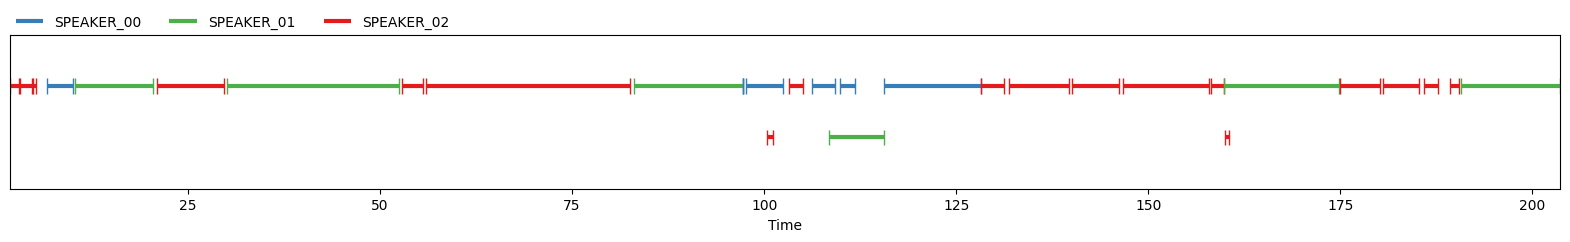

In [6]:
diarisation.support()

---

### **2. Performs Speech to Text Analysis** 

---

In [7]:
model = whisper.load_model("base.en")
result = model.transcribe(AUDIO_FILE_PATH, verbose=False, fp16=False)
transcript = result["text"]

/home/damien/Documents/ATU/machine-learning/.venv/lib/python3.12/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load

In [8]:
transcript

" Kamala Harris, is that good to be? You see, have fun. Thank you. Welcome to you both. It's wonderful to have you. It's an honor to have you both here tonight. We have inflation like very few people have ever seen before, probably the worst in our nation's history. This has been a disaster for people, for the middle class, but for every class. Donald Trump left us the worst unemployment since the Great Depression. And what we have done is clean up Donald Trump's mess. She's a Marxist. Everybody knows she's a Marxist. Her father's a Marxist professor in economics, and he taught her well. But her vice presidential pick says abortion in the ninth month is absolutely fine. He also says execution after birth. It's execution, no longer abortion because the baby is born is okay, and that's not okay with me. One does not have to abandon their faith. For deeply held beliefs to agree. The government and Donald Trump certainly should not be telling a woman what to do with her body. Pregnant wome

I need to use a github repo called Whisper X in order to merge the speaker diarisation and the transcript.

In [9]:
device = "cpu" 
audio_file = AUDIO_FILE_PATH
batch_size = 4 # reduce if low on GPU mem
compute_type = "int8" # change to "int8" if low on GPU mem (may reduce accuracy)
audio = whisperx.load_audio(AUDIO_FILE_PATH)

In [10]:
# 2. Align whisper output
model_a, metadata = whisperx.load_align_model(language_code=result["language"], device=device)
result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False) # after alignment

In [11]:
# 3. Assign speaker labels
diarize_model = whisperx.DiarizationPipeline(use_auth_token=HF_API_KEY, device=device)
diarize_segments = diarize_model(audio)
result = whisperx.assign_word_speakers(diarize_segments, result) # segments are now assigned speaker IDs

/home/damien/Documents/ATU/machine-learning/.venv/lib/python3.12/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = sequences.std(dim=-1, correction=1)


In [12]:
def format_conversation(conversation_dict):
    lines = []
    for segment in conversation_dict["segments"]:
        speaker = segment["speaker"]
        text = segment["text"].strip()
        lines.append(f"[{speaker}] {text}")

    # Join all lines with a newline
    return "\n".join(lines)

In [13]:
conversation = format_conversation(result)
print(conversation)

[SPEAKER_01] Kamala Harris, is that good to be?
[SPEAKER_01] You see, have fun.
[SPEAKER_01] Thank you.
[SPEAKER_00] Welcome to you both.
[SPEAKER_00] It's wonderful to have you.
[SPEAKER_00] It's an honor to have you both here tonight.
[SPEAKER_02] We have inflation like very few people have ever seen before, probably the worst in our
[SPEAKER_02] nation's history.
[SPEAKER_02] This has been a disaster for people, for the middle class, but for every class.
[SPEAKER_01] Donald Trump left us the worst unemployment since the Great Depression.
[SPEAKER_01] And what we have done is clean up Donald Trump's mess.
[SPEAKER_02] She's a Marxist.
[SPEAKER_02] Everybody knows she's a Marxist.
[SPEAKER_02] Her father's a Marxist professor in economics, and he taught her well.
[SPEAKER_02] But her vice presidential pick says abortion in the ninth month is absolutely fine.
[SPEAKER_02] He also says execution after birth.
[SPEAKER_02] It's execution, no longer abortion because the baby is born is oka

In [121]:
word_df = pd.DataFrame(result['word_segments'])
word_df

,word,start,end,score,speaker
0,Kamala,1.850,2.192,0.604,SPEAKER_01
1,"Harris,",2.212,2.513,0.899,SPEAKER_01
2,is,2.533,2.574,0.000,SPEAKER_01
3,that,3.157,3.398,0.624,SPEAKER_01
4,good,3.418,3.539,0.262,SPEAKER_01
...,...,...,...,...,...
572,the,201.653,201.773,0.903,SPEAKER_02
573,history,201.874,202.336,0.842,SPEAKER_02
574,of,202.737,202.817,0.833,SPEAKER_02
575,our,202.918,203.018,0.835,SPEAKER_02


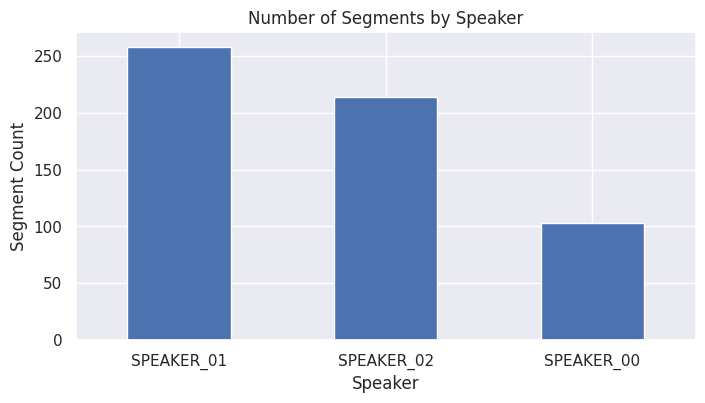

In [122]:
# Count how many words each speaker has:
segment_counts = word_df['speaker'].value_counts()

segment_counts.plot(kind='bar', figsize=(8,4), title="Number of Segments by Speaker")
plt.xlabel("Speaker")
plt.xticks(rotation=0)
plt.ylabel("Segment Count")
plt.show()

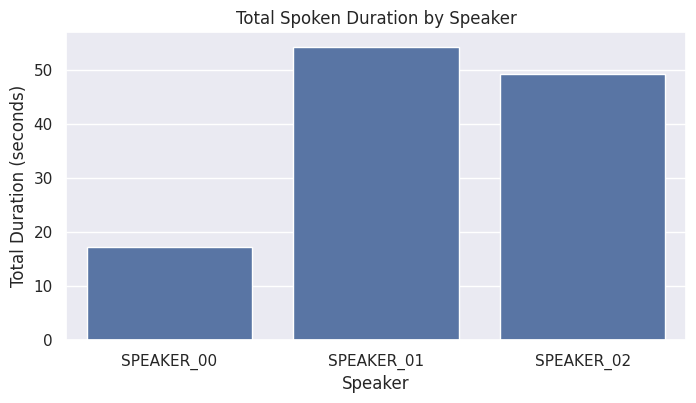

In [126]:
# Calculate the duration for each word
word_df['duration'] = word_df['end'] - word_df['start']
word_duration = word_df.groupby('speaker', as_index=False)['duration'].sum()

plt.figure(figsize=(8, 4))
sns.barplot(data=word_duration, x='speaker', y='duration')
plt.title("Total Spoken Duration by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Total Duration (seconds)")
plt.show()

In [129]:
avg_scores = word_df.groupby('speaker')['score'].mean()
avg_scores

speaker
SPEAKER_00    0.713806
SPEAKER_01    0.766647
SPEAKER_02    0.762687
Name: score, dtype: float64

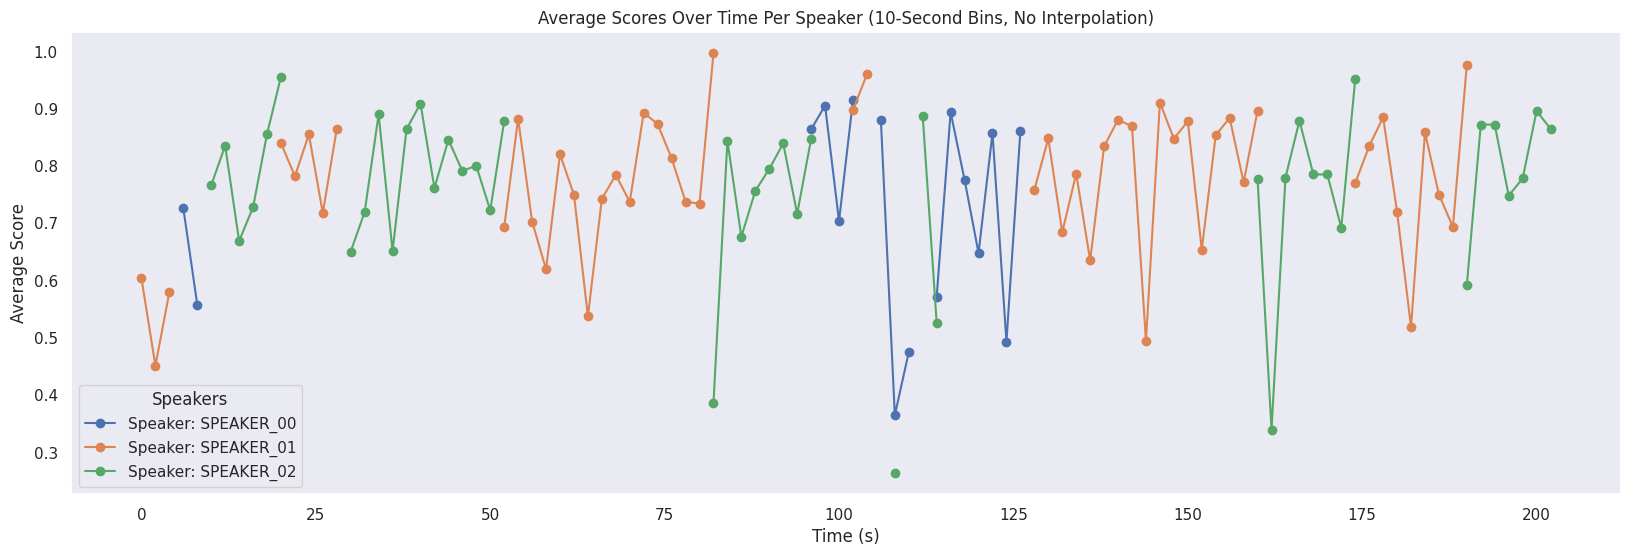

In [143]:
# Create two second time bins
word_df['time_bin'] = np.floor(word_df['start'] / 2) * 2

binned_scores = word_df.pivot_table(
    index='time_bin', columns='speaker', values='score', aggfunc='mean'
)

# Plotting the average scores over time per speaker
plt.figure(figsize=(20, 6))
for speaker in binned_scores.columns:
    plt.plot(binned_scores.index, binned_scores[speaker], marker='o', label=f'Speaker: {speaker}')

plt.xlabel('Time (s)')
plt.ylabel('Average Score')
plt.title('Average Scores Over Time Per Speaker (Two Second Bins)')
plt.legend(title='Speakers')
plt.grid()
plt.show()

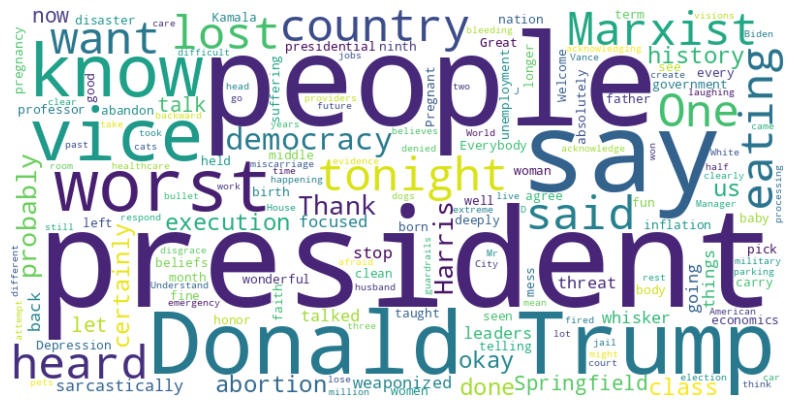

In [76]:
# Generate a Word Cloud for all speakers
all_text = " ".join(words_df["word"].values)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

# Word Cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

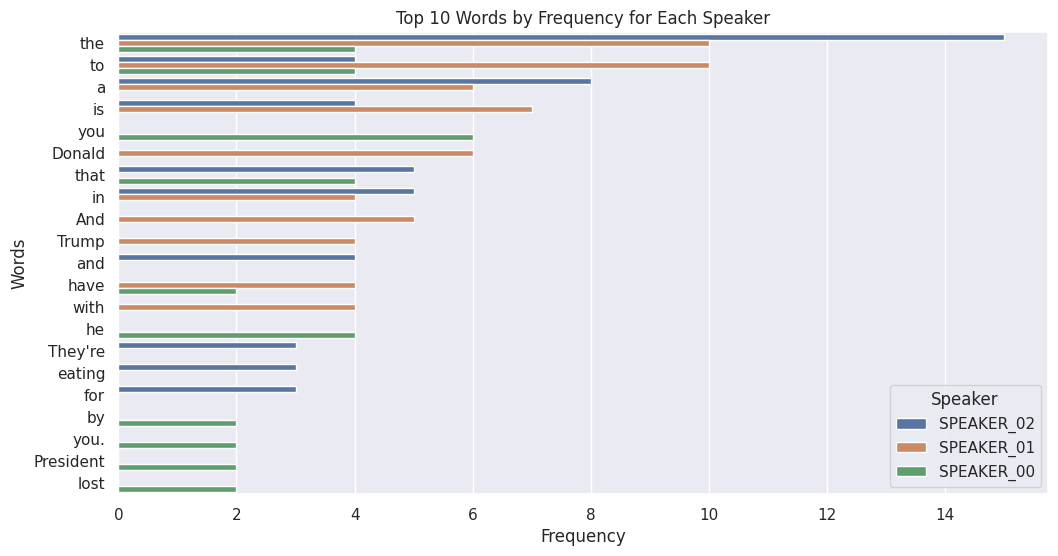

In [144]:
# Bar Chart for word frequency by speaker
word_freq_by_speaker = words_df.groupby(["speaker", "word"]).size().reset_index(name="frequency")
top_words = word_freq_by_speaker.sort_values(by="frequency", ascending=False).groupby("speaker").head(10)

# Bar Chart for word frequency
plt.figure(figsize=(12, 6))
sns.barplot(data=top_words, x="frequency", y="word", hue="speaker", dodge=True)
plt.title("Top 10 Words by Frequency for Each Speaker")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.legend(title="Speaker")
plt.show()

---

### **3. Leverage a Large Language Model**

---

In [14]:
system_prompt = """
Summarize the Debate:
    Provide an overview of the main arguments and topics discussed.

Identify Key Points:
    Highlight significant claims or issues raised by each speaker.

Analyze Rhetoric:
    Examine the tone, style, and rhetorical strategies used. Where on the political spectrum do these candidates sit?

Evaluate Logic:
    Identify any unsubstantiated claims, logical fallacies, or contradictions.

Assess Overall Impact:
    Comment on the effectiveness and potential influence of the arguments.

Instruction:
Using the above steps, analyze the debate transcript, focusing on clarity, objectivity, and key insights.
"""

In [15]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"

pipe = transformers_pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": conversation},
]
outputs = pipe(
    messages,
    max_new_tokens=1024,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [16]:
llm_output = outputs[0]["generated_text"][-1]["content"]
print(llm_output)

**Summary of the Debate:**

The debate between Kamala Harris and Donald Trump (via a video recording) revolves around various topics, including the economy, healthcare, and the 2020 presidential election. Harris argues that Trump's policies have led to economic instability, including high inflation and unemployment, particularly affecting the middle class. She also criticizes Trump's stance on abortion and his handling of the COVID-19 pandemic. Trump, on the other hand, accuses Harris of being a Marxist and claims that she is a threat to democracy. He also attempts to downplay the significance of his loss in the 2020 presidential election.

**Key Points:**

* Harris emphasizes the economic challenges facing the country, including high inflation and unemployment.
* Trump claims that Harris is a Marxist and accuses her of being a threat to democracy.
* Harris criticizes Trump's stance on abortion and his handling of the COVID-19 pandemic.
* Trump attempts to downplay the significance of 

---

### **References**

1. https://huggingface.co/pyannote/segmentation
2. http://pyannote.github.io/pyannote-core/reference.html#annotation
3. https://github.com/openai/whisper
6. https://github.com/meta-llama/llama-models
7. https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct
8. https://github.com/m-bain/whisperX




---

# END